# Were there trends in terms of job count or most demanded skills throughout 2023? 

## Data loading

In [1]:
import ast 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datasets import load_dataset
from matplotlib.ticker import PercentFormatter

def rename_months(x: pd.DataFrame) -> pd.DataFrame:
    """
    Convert the month numbers into month names (for plotting).
    """
    # Convert, e.g., 1 to Jan, 8 to Aug
    convert_month = lambda x: pd.to_datetime(x, format='%m').strftime('%b')

    x = x.reset_index()
    x['job_posted_month'] = x['job_posted_month'].apply(convert_month)
    return x.set_index('job_posted_month')


# Load data
dataset = load_dataset('lukebarousse/data_jobs')
df = dataset['train'].to_pandas()

# Drop duplicates
df = df.drop_duplicates()

# Convert date to datetime
df['job_posted_date'] = pd.to_datetime(df['job_posted_date'])

# Convert df['job_skills'] from a string to a list of strings
convert_skills = lambda x: ast.literal_eval(x) if pd.notna(x) else x
df['job_skills'] = df['job_skills'].apply(convert_skills)

/Users/alexis_reymbaut/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/alexis_reymbaut/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Time period covered by the dataset (corresponds to 2023)
df['job_posted_date'].agg(['min', 'max'])

min   2023-01-01 00:00:04
max   2023-12-31 23:59:58
Name: job_posted_date, dtype: datetime64[ns]

## Monthly trends in 2023

In [38]:
# Dummy copy
df_relevant = df.copy()

# Extract month from date
df_relevant['job_posted_month'] = df_relevant['job_posted_date'].dt.month

# Compute job count per month
df_job_month = df_relevant.groupby('job_posted_month').size()

# Rename months
df_job_month = rename_months(df_job_month)

To investigate skill trends, we take data-analyst job postings as an example.

In [54]:
# Pre-filter based on job_title_short
job_title = 'Data Analyst'
df_relevant = df[df['job_title_short'] == job_title].copy()

# Extract month from date
df_relevant['job_posted_month'] = df_relevant['job_posted_date'].dt.month

# Explode skills (which are initially contained in lists within 'job_skills')
df_skills_count = df_relevant.explode('job_skills')

# Pivot to group by month and job_skills
df_skills_count = df_skills_count.pivot_table(
    index='job_posted_month',
    columns='job_skills',
    aggfunc='size',
    fill_value=0  # In case certain skills are not requested a specific month 
)

# Sort by count
df_skills_count.loc['count'] = df_skills_count.sum()
df_skills_count = df_skills_count.sort_values('count', axis=1, ascending=False)
df_skills_count = df_skills_count.drop('count')

# Compute job counts per month
job_count = df_relevant.groupby('job_posted_month').size()

# Divide the previous skill counts by the job counts to get the likelihoods
df_skills_likelihood = 100*df_skills_count.div(job_count, axis=0)

# Rename months
df_skills_likelihood = rename_months(df_skills_likelihood)

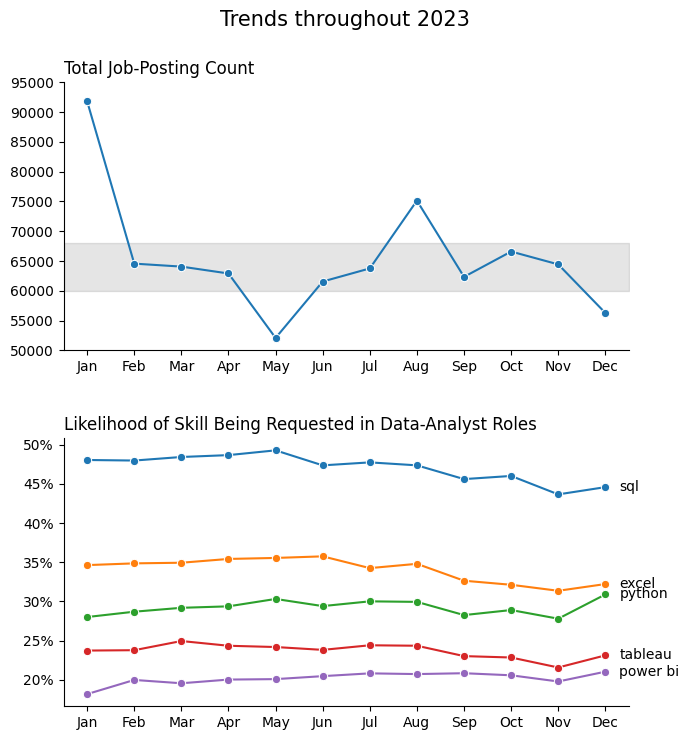

In [56]:
n_skills = 5
job_title_plot = job_title.replace(' ', '-')

fig, ax = plt.subplots(2, 1, figsize=(7, 7))

# Plot job count
df_plot = df_job_month
sns.lineplot(df_plot, dashes=False, marker='o', ax=ax[0], legend=False)
sns.despine()
ax[0].set_title('Total Job-Posting Count', loc='left')
ax[0].set_ylabel('')
ax[0].set_xlabel('')
ax[0].set_xlim([-0.5, 11.5])
ax[0].set_ylim([50000, 95000])

# Color ad-hoc range to highlight months with few/numerous job postings
ax[0].fill_between(x=[-0.5, 11.5],
                 y1=[60000, 60000],
                 y2=[68000, 68000],
                 color='k',
                 alpha=0.1)

# Plot likelihood
df_plot = df_skills_likelihood.iloc[:, :n_skills]
sns.lineplot(df_plot, dashes=False, marker='o', ax=ax[1], legend=False)
sns.despine()
ax[1].set_title(f'Likelihood of Skill Being Requested in {job_title_plot} Roles', loc='left')
ax[1].set_ylabel('')
ax[1].set_xlabel('')
ax[1].set_xlim(ax[0].get_xlim())
ax[1].yaxis.set_major_formatter(PercentFormatter(decimals=0))
for i, v in enumerate(df_plot.columns):
    ax[1].text(11.3, df_plot.iloc[-1, i], v,
               color='black', va='center')

plt.tight_layout(h_pad=3)
plt.suptitle(f'Trends throughout 2023',y=1.05, fontsize=15)
plt.show()

An ad-hoc range was colored in the top graph to highlight months with few/numerous job postings, whose job counts are outside this range.

**Breakdown:**
- (Top) Most jobs were posted in January 2023.
- (Top) There was a resurgence in job postings in August 2023.
- (Top) Among the remaining months, May and December 2023 showed fewer job postings.
- (Bottom) While the number of job postings was previously shown to be quite time-dependent, the likelihood of top skills being requested in data-analyst job postings was rather constant throughout 2023.

**NB:** The skill likelihood behaves similarly for other main data roles.